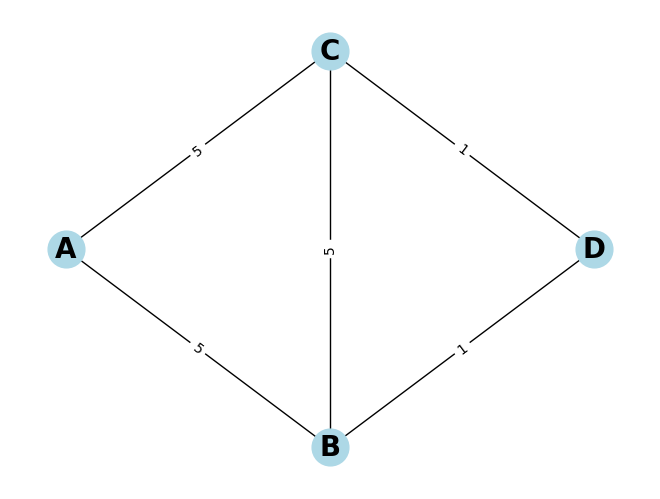

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from discrete_exterior_calculus import DEC

graph = nx.Graph()

graph.add_node("A")
graph.add_node("B")
graph.add_node("C")
graph.add_node("D")

# SCENARIO 1
graph.add_edge("A", "B", weight=5)
graph.add_edge("A", "C", weight=5)
graph.add_edge("B", "C", weight=5)
graph.add_edge("B", "D", weight=1)
graph.add_edge("C", "D", weight=1)

# draw the graph with edge weights show
pos = {
    "A": np.array([-1, 0.5]),
    "B": np.array([0, 0]),
    "C": np.array([0, 1.0]),
    "D": np.array([1, 0.5]),
}
#

# # SCENARIO 2
# graph.add_edge("A", "B", weight=5)
# graph.add_edge("A", "C", weight=5)
# graph.add_edge("B", "C", weight=5)
# graph.add_edge("B", "D", weight=1)
# graph.add_edge("C", "D", weight=1.4)

# # draw the graph with edge weights show
# pos = {
#     "A": np.array([-1, 0.5]),
#     "B": np.array([0, 0]),
#     "C": np.array([0, 1.0]),
#     "D": np.array([1, 0]),
# }
##

nx.draw(
    graph,
    pos,
    with_labels=True,
    node_size=700,
    node_color="lightblue",
    font_size=20,
    font_weight="bold",
)
edge_labels = nx.get_edge_attributes(graph, "weight")


nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels);

In [8]:
# for each edge, get the nodes that are lie on 2-hop paths from the source to the target
from discrete_exterior_calculus.triangulate import edge

opposing_nodes_dict = {}

for edg_ in graph.edges():
    start, end = tuple(np.array(edge(*edg_)))

    source_neighbors = list(graph.neighbors(start))
    target_neighbors = list(graph.neighbors(end))
    intersection = list(set(target_neighbors).intersection(set(source_neighbors)))
    opposing_nodes_dict[edg_] = intersection


/Users/theoruterwurtzen/Desktop/MSc Thesis/code/app/discrete_exterior_calculus/DEC.py:68: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  self.laplace_matrix = -spsla.spsolve(


NameError: name 'edge_values' is not defined

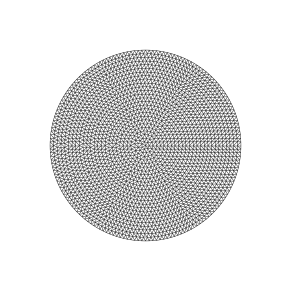

In [11]:
def convert_mesh_to_graph(mesh: DEC.Mesh) -> tuple[nx.Graph, dict]:
    graph = nx.Graph()
    for i, face in enumerate(mesh.faces):
        for j in range(3):
            a, b = edge(face[j], face[(j + 1) % 3])

            if not graph.has_edge(a, b):
                graph.add_edge(a, b)

    pos_map = {i: mesh.vertices[i][[0, 2]] for i in range(len(mesh.vertices))}

    return graph, pos_map


def add_edge_values_to_graph(mesh, graph, edge_values):
    for i, (a, b) in enumerate(mesh.edges):
        edge_value = edge_values[i] * 10 + 0.1
        graph[a][b]["weight"] = edge_value.round(2)


from discrete_exterior_calculus import triangulate

tri, positions = triangulate.triangulate_mesh_with_edge_distances(mesh)

mesh = DEC.Mesh.from_obj("../meshes/unit-disc.obj")

g, pos_map = convert_mesh_to_graph(mesh)
fig, ax = plt.subplots(1, 1, figsize=(1, 1), dpi=300)
ax.set_aspect("equal")
ax.axis("off")
nx.draw(g, pos_map, ax=ax, node_size=0, edge_color="black", width=0.1)
add_edge_values_to_graph(
    mesh,
    g,
)
edge_labels = nx.get_edge_attributes(g, "weight")
nx.draw_networkx_edge_labels(g, pos_map, edge_labels=edge_labels, ax=ax, font_size=5);

In [ ]:
from discrete_exterior_calculus import dijkstra

distances = dijkstra.dijkstra(startpos=(0, 0), graph=g, positions=vertices)
distances = (distances - distances.min()) / (distances.max() - distances.min())
distances = np.sin(distances * np.pi * 0.1)

# use matplotlib tripcolor to plot the mesh with the distances as colors
fig, ax = plt.subplots(1, 1, figsize=(1, 1), dpi=300)
ax.axis("off")
ax.set_aspect("equal")
ax.tripcolor(triang, distances, cmap="viridis", shading="gouraud");

In [ ]:
from discrete_exterior_calculus import hyperbolic_laplacian
import scipy.sparse.linalg as spsla


areas, cotangents = (
    hyperbolic_laplacian.get_triangle_area_and_interior_angles_from_lengths(
        np.array(list(tris.items())).reshape(-1, 6)
    )
)

star0 = hyperbolic_laplacian.compute_star0(areas, mesh.tri_map)
star1_circ = hyperbolic_laplacian.compute_star1_circ(mesh.faces, mesh.edges, cotangents)
laplacian = -spsla.spsolve(star0, mesh.d0.T @ star1_circ @ mesh.d0)

/var/folders/vc/1d1z34l176gfm4swwfttvslr0000gn/T/ipykernel_27496/108363927.py:13: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  laplacian = -spsla.spsolve(star0, mesh.d0.T @ star1_circ @ mesh.d0)


In [ ]:
import numpy as np
from discrete_exterior_calculus import DECMesh
from probabilistic_numerics import heat_kalman
from traditional_numerics import heat_solver as hs
import scipy.sparse as sps
import jax.numpy as jnp

boundary_nodes = mesh.boundary_mask.copy()

n = len(mesh.vertices)

boundary_values = np.sin(3 * np.arctan2(mesh.vertices[:, 0], mesh.vertices[:, 2]))

derivatives = 2

initial_value = np.zeros(n * (derivatives + 1))
above_mask = (mesh.vertices[:, 1] > 0).astype(float) * 0 + 1
distance_to_center = np.linalg.norm(mesh.vertices[:, [0, 2]] * [1.5, 3], axis=1)
rbf = np.exp(-3 * (distance_to_center**2)) * 1

initial_value[:n] = above_mask * rbf
initial_value[:n][mesh.boundary_mask] = boundary_values[mesh.boundary_mask]
# initial_value[n : 2 * n] = -laplacian @ initial_value[:n]

timesteps = 10
delta_time = 0.5

p_means, p_chol_covs = heat_kalman.PIVP_heat_solve_cholesky(
    laplace_matrix=-laplacian,
    initial_mean=initial_value,
    derivatives=derivatives,
    timesteps=timesteps,
    delta_time=delta_time,
    length_scale=1,
)


newname = "bitch_wave.json"
mesh.dump_to_JSON(
    newname,
    {
        "Initial Value": initial_value[:n],
        "Probabilistic Heat Equation": {
            "data": p_means[:, :n],
            "start": 0,
            "end": 1,
        },
        "areas": np.diagonal(mesh.star0.toarray()),
    },
)
print("saved as", newname)


Starting PIVP_heat_solve
8
Built IWP prior
Discretized IWP prior
Filtered on PDE observations
Smoothed PDE observations, returning


FileNotFoundError: [Errno 2] No such file or directory: '../../produced_solutions/bitch_wave.json'